# Laboratory Work 1

In [219]:
from graphviz import Digraph, Source
import random 

In [220]:
class FiniteAutomaton:
    def __init__(self, states, alphabet, transitions, initial_state, accept_states):
        self.states = states
        self.alphabet = alphabet
        self.transitions = transitions
        self.initial_state = initial_state
        self.accept_states = accept_states

    def accepts(self, input_string):
        curr_state = self.initial_state

        for symbol in input_string:
            # The symbol is not in the automaton's alphabet
            if symbol not in self.alphabet:
                return False 

            # Check if there's a transition defined for the current state and symbol
            if curr_state in self.transitions and symbol in self.transitions[curr_state]:
                curr_state = self.transitions[curr_state][symbol]
            else:
                return False 

        # Check if the current state after processing the input string is an accept state
        return curr_state in self.accept_states
    
    # For testing purposes
    def create_diagram(self):
        dot = Digraph(comment='Finite Automaton')
        dot.attr(rankdir='LR') 

        # Add states
        for state in self.states:
            if state in self.accept_states:
                dot.node(state, state, shape='doublecircle')
            else:
                dot.node(state, state)

        # Mark tinitial state
        dot.node('', '', shape='none')
        dot.edge('', self.initial_state)

        # Add transitions
        for state, transitions in self.transitions.items():
            for symbol, next_state in transitions.items():
                dot.edge(state, next_state, label=symbol)

        source = Source(dot.source)
        return source

In [221]:
class Grammar:
    def __init__(self, non_terminals, terminals, rules, start='S'):
        self.non_terminals = non_terminals
        self.terminals = terminals
        self.rules = rules
        self.start = start
        self.type = self.get_type()

    def generate_string(self, symbol=None, len=0, max_len=15):
        # If no symbol is provided, use the start symbol
        if symbol is None:
            symbol = self.start

        # Check for exceeding the maximum length
        if len > max_len:
            return ''

        # Base case: symbol is terminal
        if symbol in self.terminals:
            return symbol

        if symbol in self.rules:
            # Random production
            production = random.choice(self.rules[symbol])
            result = ''
            for sym in production:
                result += self.generate_string(sym, len + 1, max_len)
            return result

        # The symbol doesn't match anything in the production
        return ''

    def get_type(self):
        left, right = False, False

        # Flatten the list of production rules to easily iterate over each right side
        rhs = [item for inner_list in self.rules.values() for item in inner_list]
        # Iterate over each right side of the production rules that have 2 symbols
        for right_side in filter(lambda x: len(x) == 2, rhs):
            # If the first symbol is a terminal and the second is a non-terminal, it's a right regular rule
            if right_side[0] in self.terminals and right_side[1] in self.non_terminals:
                right = True
            # If the first symbol is a non-terminal and the second is a terminal, it's a left regular rule
            elif right_side[0] in self.non_terminals and right_side[1] in self.terminals:
                left = True
            # If neither of the above conditions is met, the production rule format is invalid
            else:
                raise ValueError('Invalid production rule format')

        # If both left and right are True, the grammar is not regular
        if left and right:
            raise ValueError('The grammar is not regular')

        if left:
            return 'left'

        return 'right'

    def convert_to_fa(grammar):
        final_state = 'DEAD'
        transitions = {}

        for non_terminal in grammar.non_terminals:
            transitions[non_terminal] = {}

        for non_terminal, productions in grammar.rules.items():
            for production in productions:
                if len(production) == 1:  # Single terminal production
                    transitions[non_terminal][production] = final_state
                elif grammar.type == 'right':  # Right-linear production
                    transition, new_state = production[0], production[1]
                    transitions[non_terminal][transition] = new_state
                elif grammar.type == 'left':  # Left-linear production
                    transition, new_state = production[1], production[0]
                    transitions[non_terminal][transition] = new_state

        return FiniteAutomaton(
            states=grammar.non_terminals + [final_state],
            alphabet=grammar.terminals,
            transitions=transitions,
            initial_state=grammar.start,
            accept_states=[final_state]
        )

## Test - Variant 30

$$
\begin{align*}
V_N &= \{S, B, C, D\} \\
V_T &= \{a, b, c\} \\
P &= \{ S \to aB,
  B \to bS \,|\, aC \,|\, c,
  C \to bD,
  D \to c \,|\, aC
\}
\end{align*}
$$

In [222]:
non_terminals= ['S', 'B', 'C', 'D']
terminals = ['a', 'b', 'c']
rules = {
    'S': ['aB'],
    'B': ['bS', 'aC', 'c'],
    'C': ['bD'],
    'D': ['c', 'aC']
}


grammar = Grammar(non_terminals, terminals, rules)
dfa = grammar.convert_to_fa()

print(f"Alphabet: {dfa.alphabet}")
print(f"States: {dfa.states}")
print(f"Initial state: {dfa.initial_state}")
print(f"Accepted states: {dfa.accept_states}")
print("Transitions:")
for state, transitions in dfa.transitions.items():
    print(f"Transitions from {state}:")
    for symbol, next_state in transitions.items():
        print(f"  {symbol} -> {next_state}")

Alphabet: ['a', 'b', 'c']
States: ['S', 'B', 'C', 'D', 'DEAD']
Initial state: S
Accepted states: ['DEAD']
Transitions:
Transitions from S:
  a -> B
Transitions from B:
  b -> S
  a -> C
  c -> DEAD
Transitions from C:
  b -> D
Transitions from D:
  c -> DEAD
  a -> C


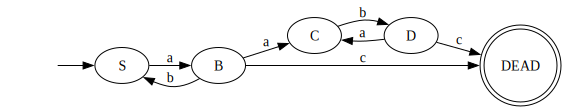

In [223]:
dfa.create_diagram()

In [224]:
print("Generated strings:")
for _ in range(5):
    gen_string = grammar.generate_string(max_len=15)
    print(f"{gen_string} ({'accepted' if dfa.accepts(gen_string) else 'rejected'})") 

Generated strings:
ac (accepted)
aabababc (accepted)
abababaababc (accepted)
abababac (accepted)
abaabc (accepted)


In [225]:
tested_strings = ['ab', 'abab', 'abababc', 'aacbc']
for string in tested_strings:
    print(f"{string} - {'accepted' if dfa.accepts(string) else 'rejected'}")

ab - rejected
abab - rejected
abababc - rejected
aacbc - rejected
